In [215]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn.objects as so
import numpy as np

score_order = [
    'activations-que', 
    'activations-mahalanobis', 
    'activations-lof', 
    'activations-isoforest', 
    'activations-likelihood',
    'activations-em',
    'activations-pca-mahalanobis',
    'attribution-mahalanobis\nmean',
    'attribution-mahalanobis\npcs',
    'attribution-mahalanobis\nraw',
    'attribution-mahalanobis\nedge_mean',
    'attribution-mahalanobis\ngrad_norm',
    'attribution-que\nmean', 
    'attribution-que\npcs',
    'attribution-que\nraw',
    'attribution-que\ngrad_norm',
    'attribution-lof\nmean',
    'attribution-lof\npcs',
    'attribution-lof\nraw',
    'attribution-lof\nedge_mean',
    'attribution-lof\ngrad_norm',
    'attribution-isoforest\nmean',
    'attribution-isoforest\npcs',
    'attribution-isoforest\nraw',
    'attribution-isoforest\nedge_mean',
    'attribution-isoforest\ngrad_norm',
    'attribution-mahalanobis\nconcat-mean',
    'attribution-que\nconcat-mean',
    'attribution_activations-mahalanobis\nmean',
    'attribution_activations-mahalanobis\nmean-ensemble',
    'attribution_activations-mahalanobis\npcs',
    'attribution_activations-mahalanobis\nraw',
    'attribution_activations-mahalanobis\ngrad_norm',
    'probe-mahalanobis\nmean',
    'probe-que\nmean',
    'probe-mahalanobis\npcs',
    'probe-que\npcs',
    'probe-lof\nmean',
    'probe-lof\npcs',
    'probe-isoforest\nmean',
    'probe-isoforest\npcs',
    'probe-isoforest\nraw',
    'probe-isoforest\nedge_mean',
    'probe-isoforest\ngrad_norm',
    'probe-mahalanobis\nconcat-mean',
    'probe-que\nconcat-mean',
    'probe-lof\nconcat-mean',
    'probe-lof\nconcat-pcs',
    'probe_activations-mahalanobis\nmean',
    'probe_activations-mahalanobis\nmean-ensemble',
    'rephrase', 
    'misconception'
]

online_score_order = [i for i in score_order if not any([j in i for j in ['likelihood', 'que', '-em']])]
offline_score_order = [i for i in score_order if any([j in i for j in ['likelihood', 'que', '-em']])]

# Define the path to the logs directory
logs_dir = '../logs/quirky'
mart_logs_dir = '../logs/mart_logs/quirky/pca_results_hard'
# Walk through the directory

def get_basename_or_parent(path):
    basename = os.path.basename(path)
    if basename.split('-')[0] != 'all':
        return basename
    else:
        # If basename is empty, get the parent directory's basename
        parent_path = os.path.dirname(path)
        return os.path.basename(parent_path)

def get_layer(layer_tag):
    if layer_tag == 'all':
        return -1
    elif layer_tag == 'out':
        return 32
    else:
        return int(re.findall(r'\d+', layer_tag)[0])

filters = {
    'rand_vs_nonrand': lambda root, dirs, files: 'eval.json' in files and 'probe_trajectory' in get_basename_or_parent(root) and
     ('-rand_retrain' in get_basename_or_parent(root) or 'nrand_retrain2' in get_basename_or_parent(root) or '--' in get_basename_or_parent(root)),
    'layerwise_activations': lambda root, dirs, files: 'eval.json' in files and len(get_basename_or_parent(root).split('-')) > 4 and 'activations' in get_basename_or_parent(root),
    'layerwise_agnostic': lambda root, dirs, files: 'eval.json' in files and len(get_basename_or_parent(root).split('-')) > 4 
     and 'capitals' not in root and 'authors' not in root and
    ('activations' in root or 'iterative_rephrase' in root or 'attribution' in root or 'probe' in root or 'misconception' in root),
    'none': lambda root, dirs, files: 'eval.json' in files
}
def get_data(filter, train_from_test=False, log_dir=logs_dir, score_order = online_score_order):
    results = []
    for root, dirs, files in os.walk(log_dir):
        if filter(root, dirs, files):
            # Load the main eval.json
            main_eval_path = os.path.join(root, 'eval.json')
            with open(main_eval_path, 'r') as f:
                main_eval = json.load(f)
            if 'probe' in root and 'Mistral' not in root:
                continue
            
            if 'attribution_activations' in root and 'Mistral' in root:
                continue
            
            if 'attribution-' in root and 'Mistral' not in root:
                continue

            # Extract dataset name from the folder structure    
            name_parts = get_basename_or_parent(root).split('-')
            dataset = name_parts[0]
            score = name_parts[1]
            features = None
            alpha = None
            layer = None
            if len(name_parts) > 2:
                features = name_parts[2]
                features = features.replace('activations_attribution', 'attribution_activations')

            if name_parts[-1].isdigit():
                alpha = int(name_parts[-1])
            rand = 0 if 'nrand' in get_basename_or_parent(root) else 1
             
            if features.split('_')[0] == 'attribution':
                if 'refactor' not in root:
                    score = features + '-' + score + '\n' + name_parts[-1]
                else:
                    score = features + '-' + score + '\n' + name_parts[-1]
            if features.split('_')[0] == 'probe':
                score = features + '-' + score + '\n' + name_parts[-1]
                # Append the results to the list
            if features.split('_')[0] == 'activations':
                score = features + '-' + score
            if 'misconception' in root:
                score = 'misconception'
            if 'rephrase' in root:
                score = 'rephrase'
            if name_parts[-1] == 'concat':
                score += f'-{name_parts[-2]}'
            if 'ensemble' in root:
                score += '-ensemble'

            for key, value in main_eval.items():
                layer = get_layer(key)
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'random_names': rand,
                    'auc_roc': value['AUC_ROC'],
                    'auc_roc_agree': value['AUC_ROC_AGREE'],
                    'auc_roc_disagree': value['AUC_ROC_DISAGREE'],
                })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    # Order the datasets
    dataset_order = [
        'population', 
        'nli', 
        'sciq', 
        'sentiment',  
        'hemisphere',  
        'addition', 
        'subtraction', 
        'multiplication', 
        'modularaddition', 
        'squaring'
    ]
    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)

    df = df.drop_duplicates(subset=['dataset', 'score', 'layer'])

    return df

def barplot_by_dataset(df, compare='random_names', disagree=False):
    if disagree:
        y_col = 'auc_roc_disagree'
        title = f'Mean AUC-ROC by Dataset and {compare} (only where Alice/Bob disagree)'
    else:
        y_col = 'auc_roc'
        title = f'Mean AUC-ROC by Dataset and {compare}'
    grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='dataset', ascending=True)
    # Create the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dataset', y=y_col, hue=compare, data=grouped_df)

    plt.title(title)
    plt.xlabel('Dataset')
    plt.ylabel('Alice vs Bob AUC')
    plt.legend(title=compare)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'auc_roc_all': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
    }

def plot_auc_roc_by_layer_by_score(
        df, 
        multilayer=True,
        disagree=False):
    df['layer']=df['layer'].astype(int)
    df = df[df['score'].isin(score_order)]

    if disagree:
        y_col = 'auc_roc_disagree'
        title = '{} (disagree only)'
    else:
        y_col = 'auc_roc'
        title = '{} (all examples)'

    if multilayer:
        df = df[df['layer'] >= 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        df['title'] = df['score'].astype(str) + ' ' + title
        df = df.sort_values(by=['dataset', 'layer'])
        g = (
            so.Plot(df, x="layer", y=y_col, color="dataset", marker="dataset")
            .facet(col="score", wrap=3)
            .add(so.Line(), so.Agg(), so.Jitter(x=2))
            .label(x="Layer", y="Alice vs Bob AUC", title=title.format)
            .theme({
                "figure.figsize": (12, 4*(len(df['score'].unique()) + 3)//3),
            })
        )
    else:
        df = df[df['layer'] < 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        unique_scores = df['score'].unique()
        
        fig, ax = plt.subplots(1,1, figsize=(20, 12))  # Increased figure size
        plot_df = df.sort_values(by=['dataset', 'layer'])
        
        g = sns.barplot(data=plot_df, x="score", y="auc_roc", ax=ax, hue="dataset", dodge=True)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
        ax.set_ylim(df['auc_roc'].min()*0.9, 1.03)
        ax.set_xlabel(None)
        ax.set_title('AUC-ROC by Dataset for Different Scores')


    plt.tight_layout()
    plt.show()

    return g


/tmp/ipykernel_2723118/1099315873.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()


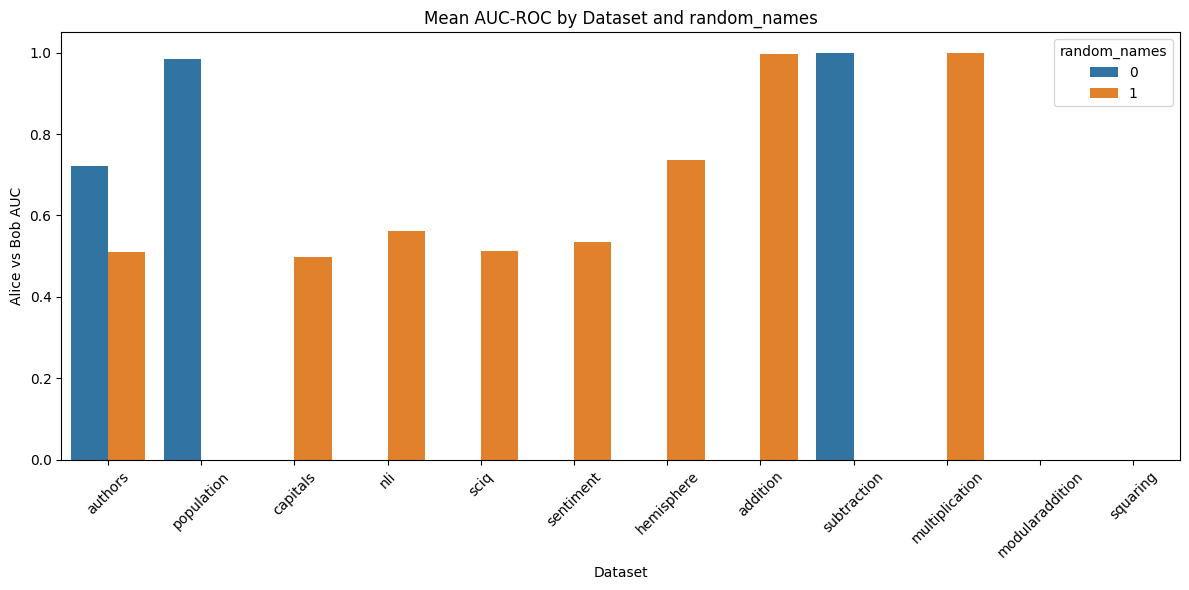

In [2]:
df = get_data(filters['rand_vs_nonrand'])
barplot_by_dataset(df[~df['dataset'].isin(['modularaddition', 'squaring'])], compare='random_names')

probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobi

<Figure size 640x480 with 0 Axes>

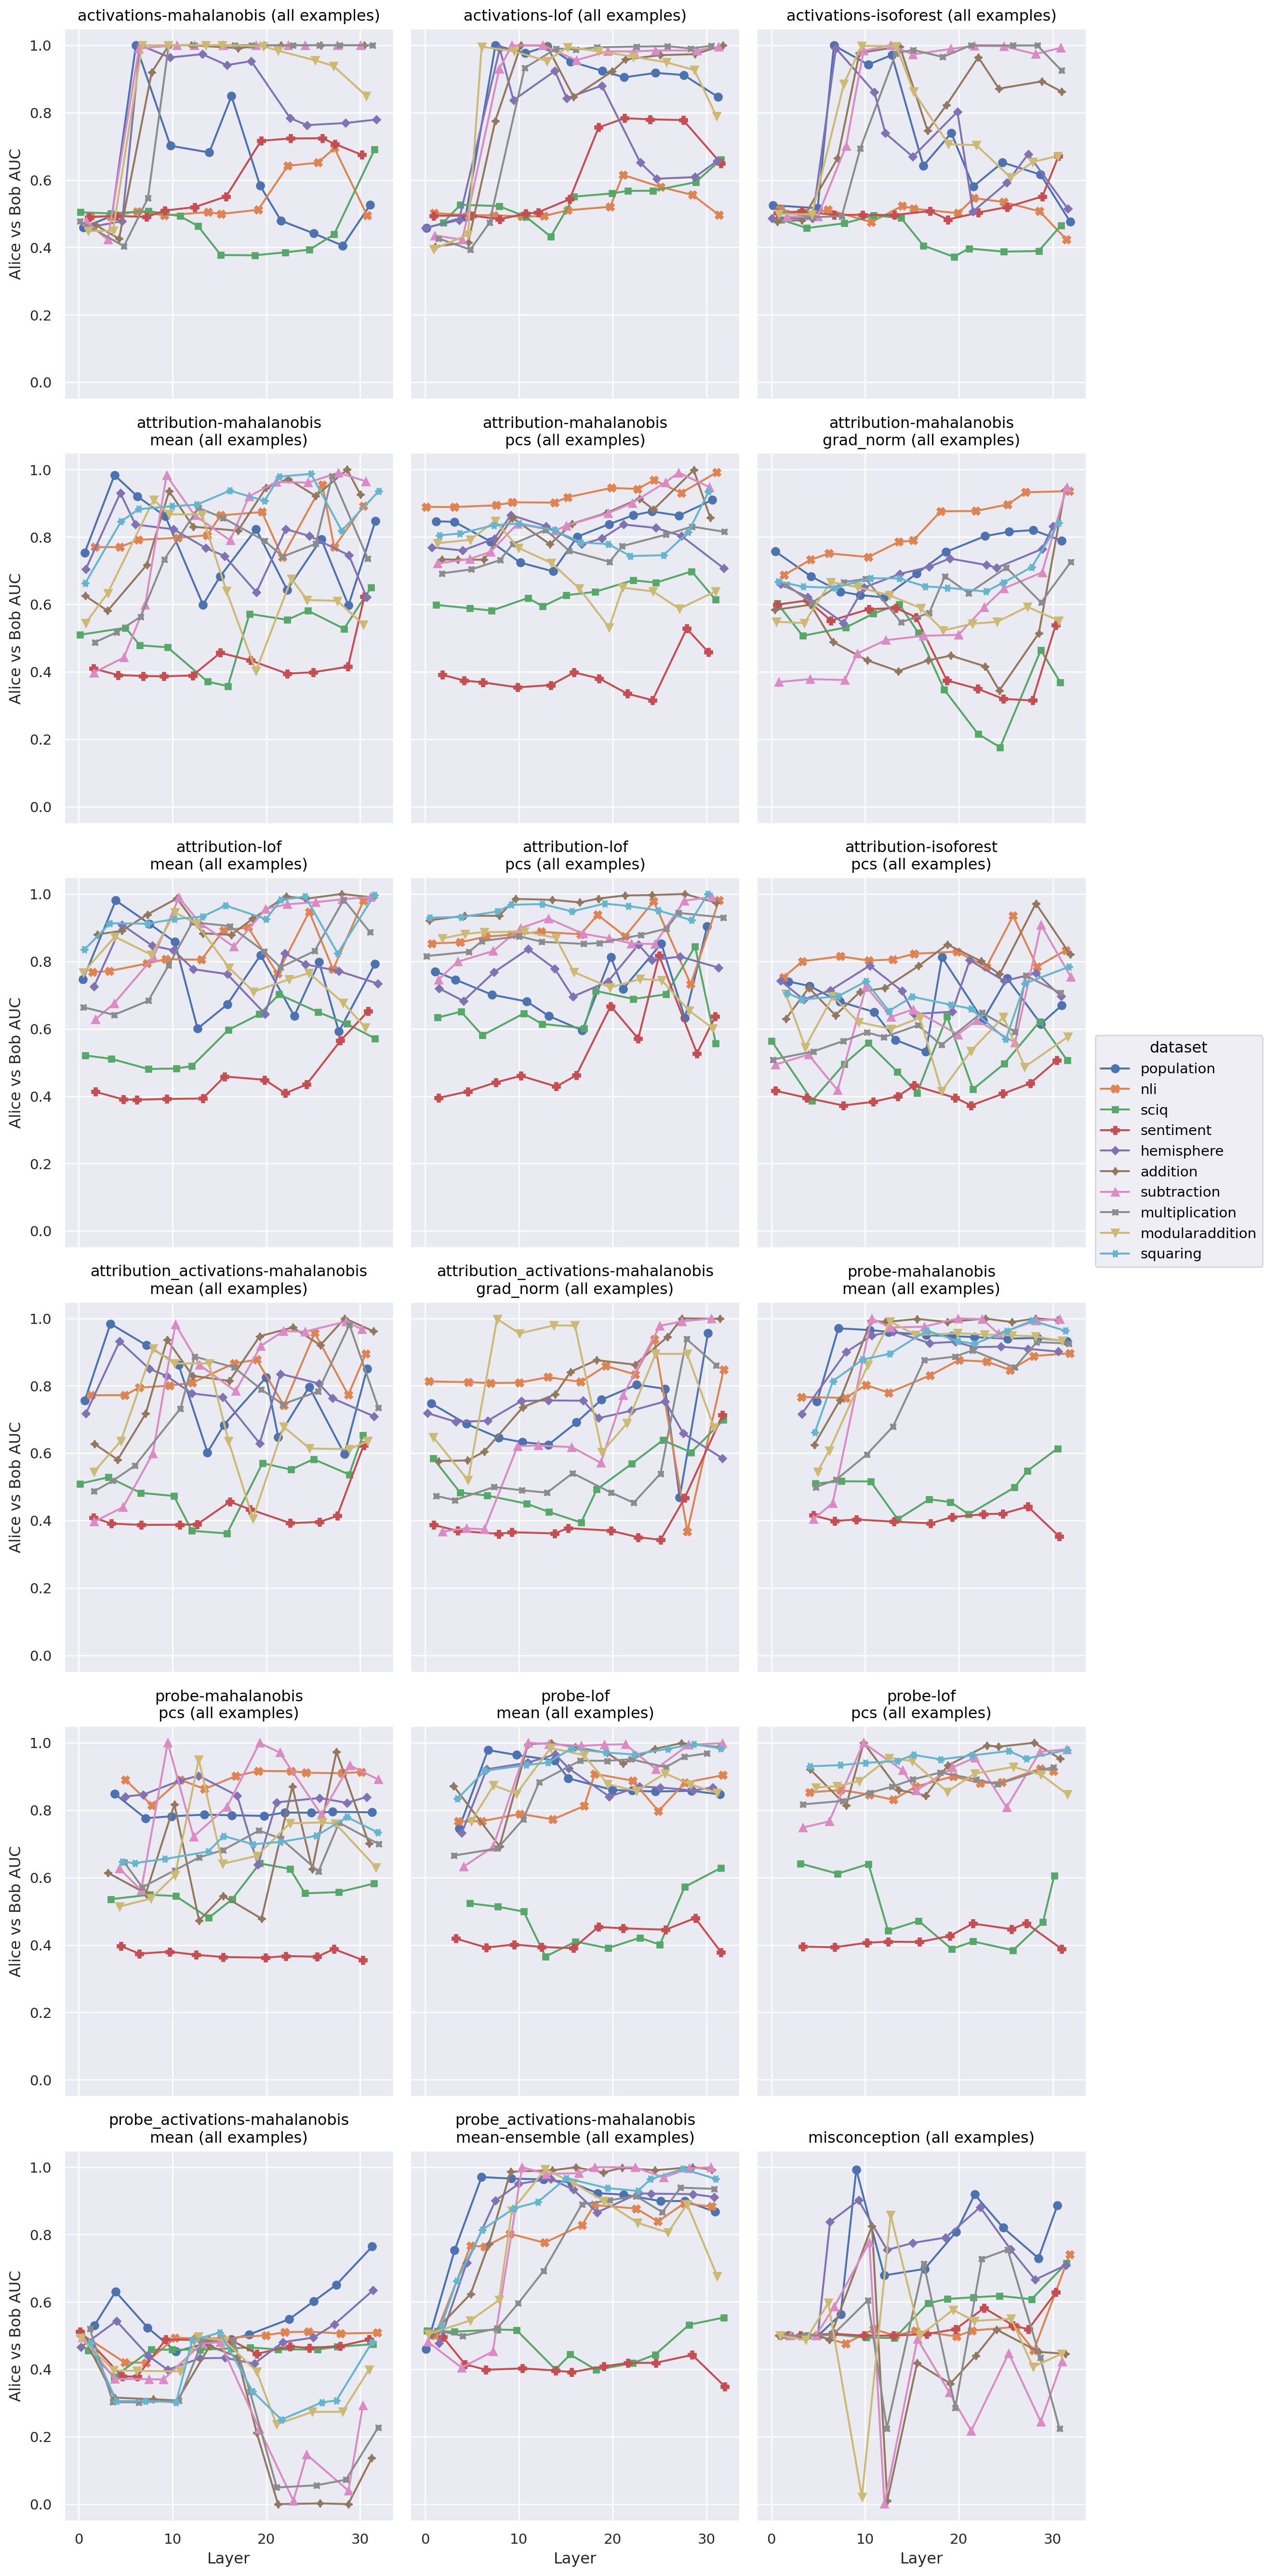

In [218]:
df = get_data(filters['layerwise_agnostic'])
df.loc[df['score'].isin(['rephrase']), 'layer'] = -1
plot_auc_roc_by_layer_by_score(df)

<Figure size 640x480 with 0 Axes>

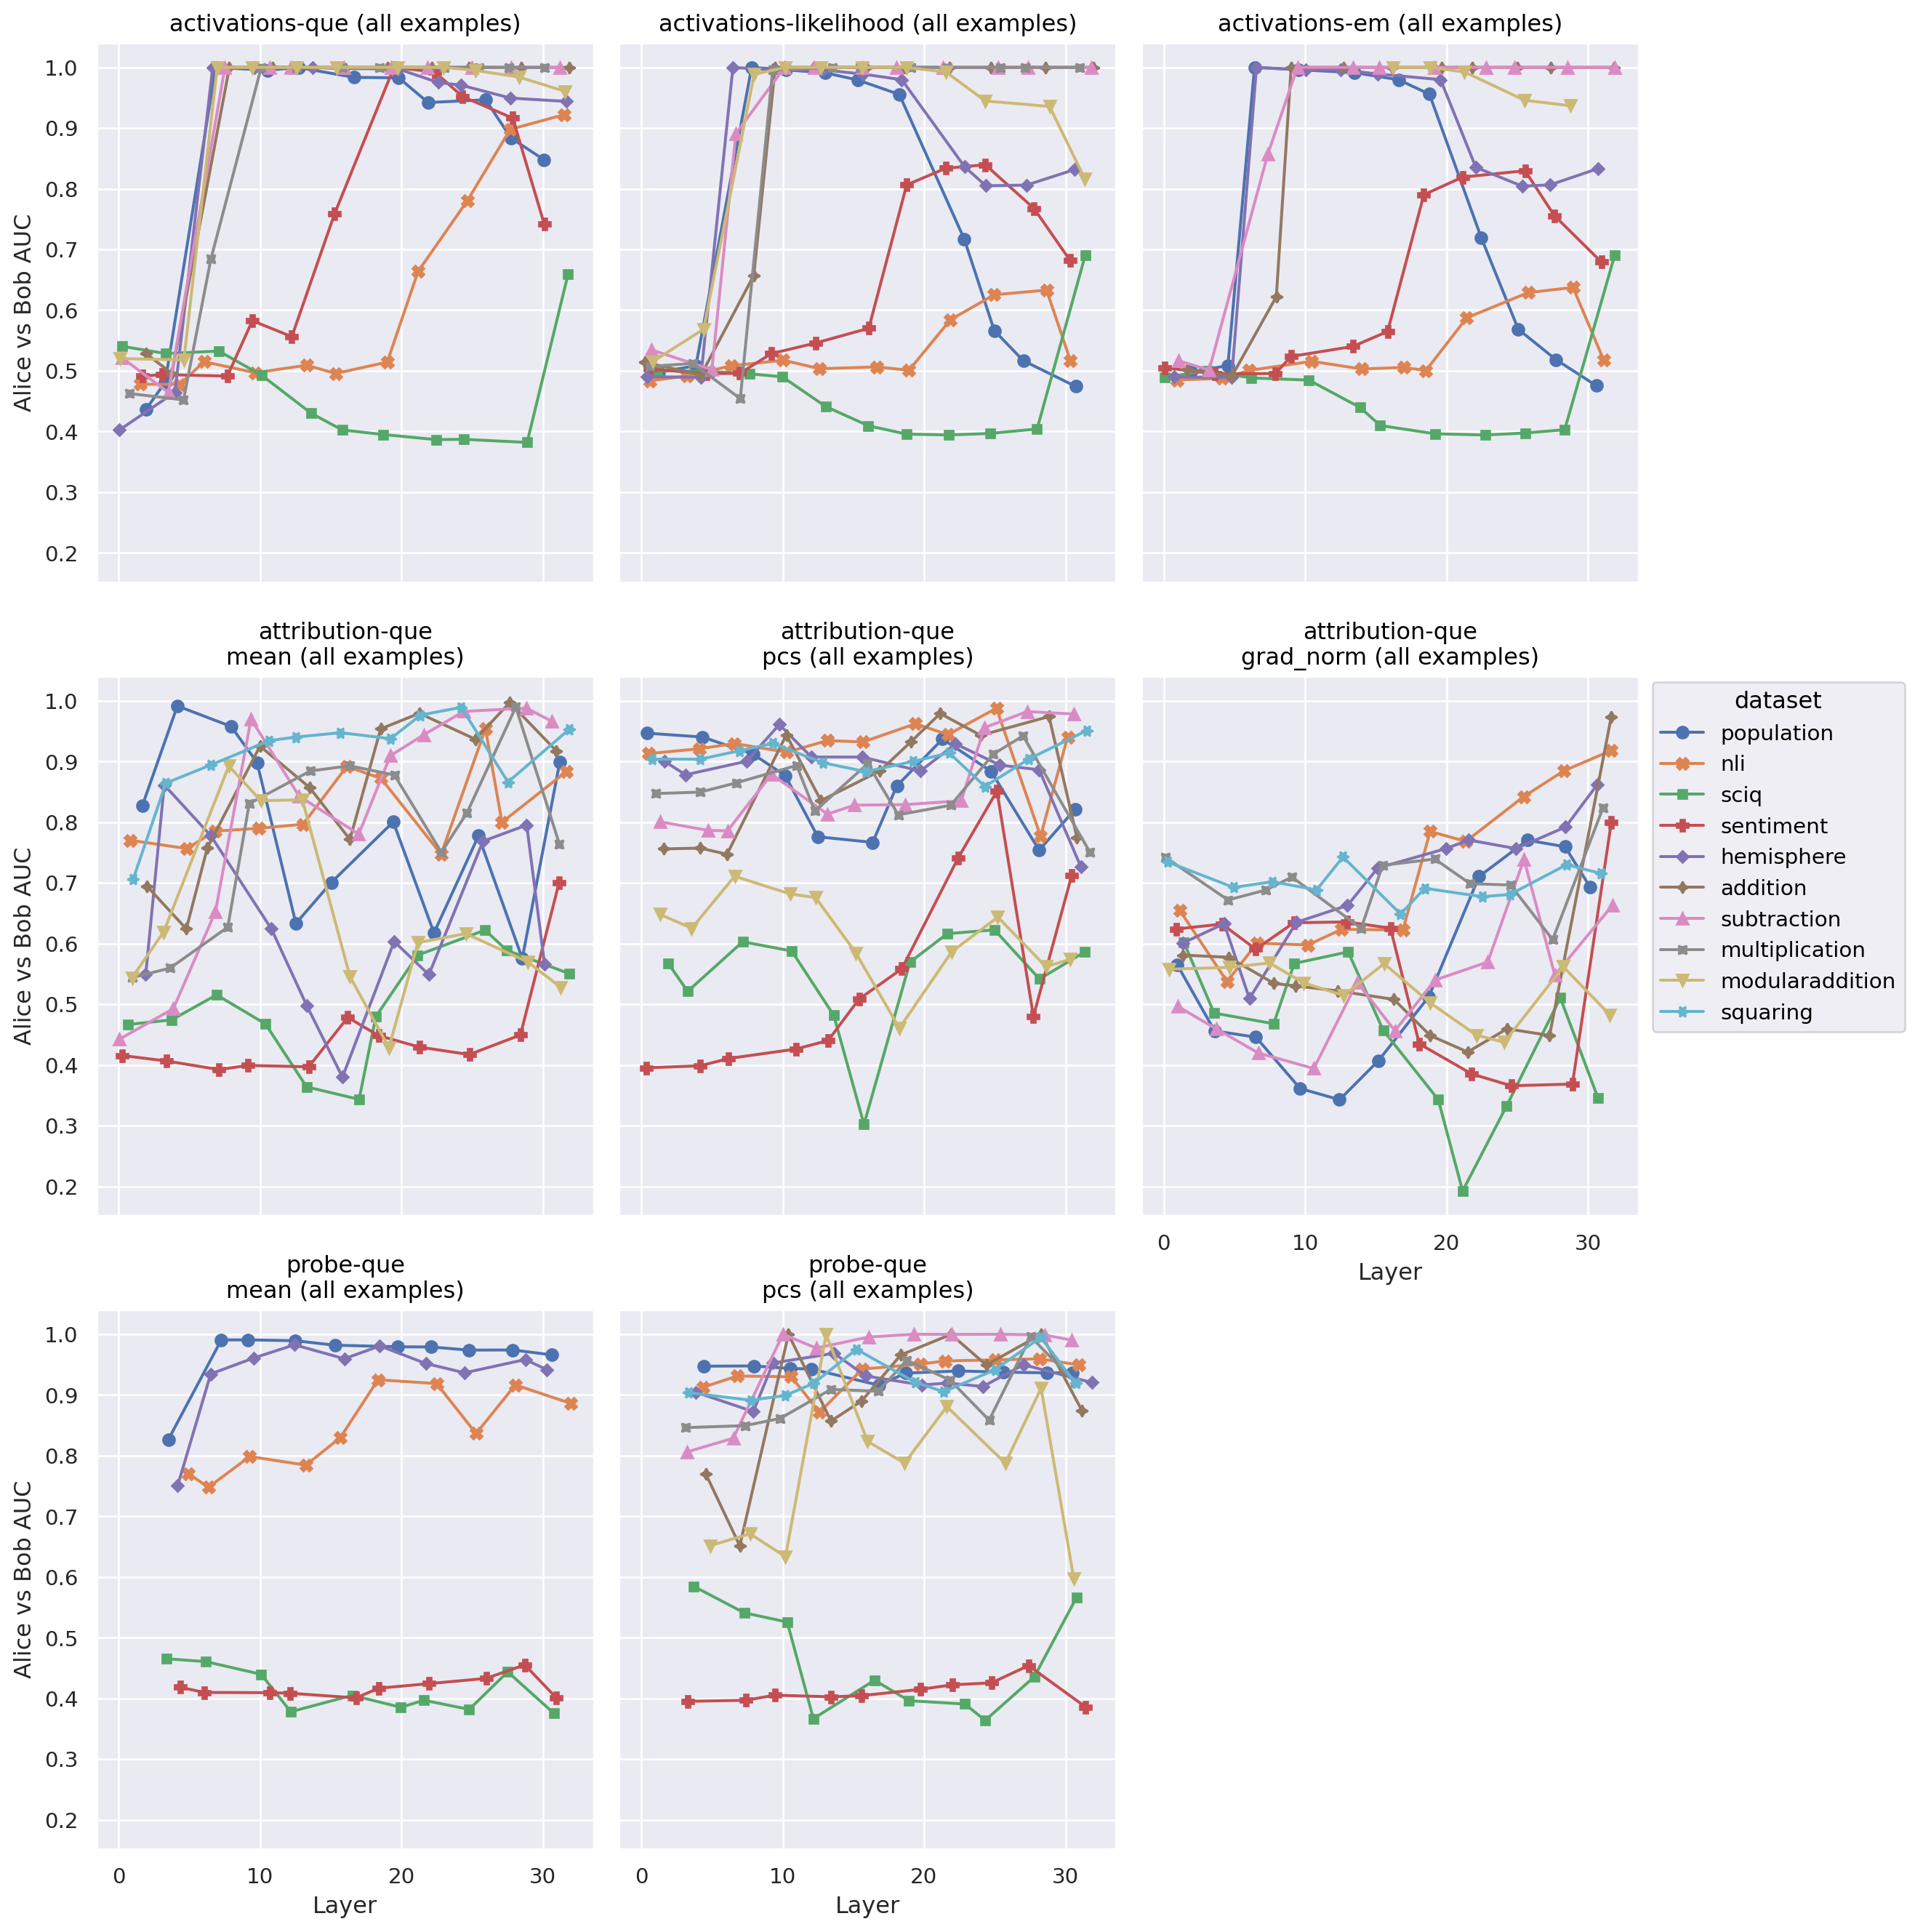

In [89]:
df = get_data(filters['layerwise_agnostic'], score_order=offline_score_order)
df.loc[df['score'].isin(['rephrase']), 'layer'] = -1

plot_auc_roc_by_layer_by_score(df)

<Figure size 640x480 with 0 Axes>

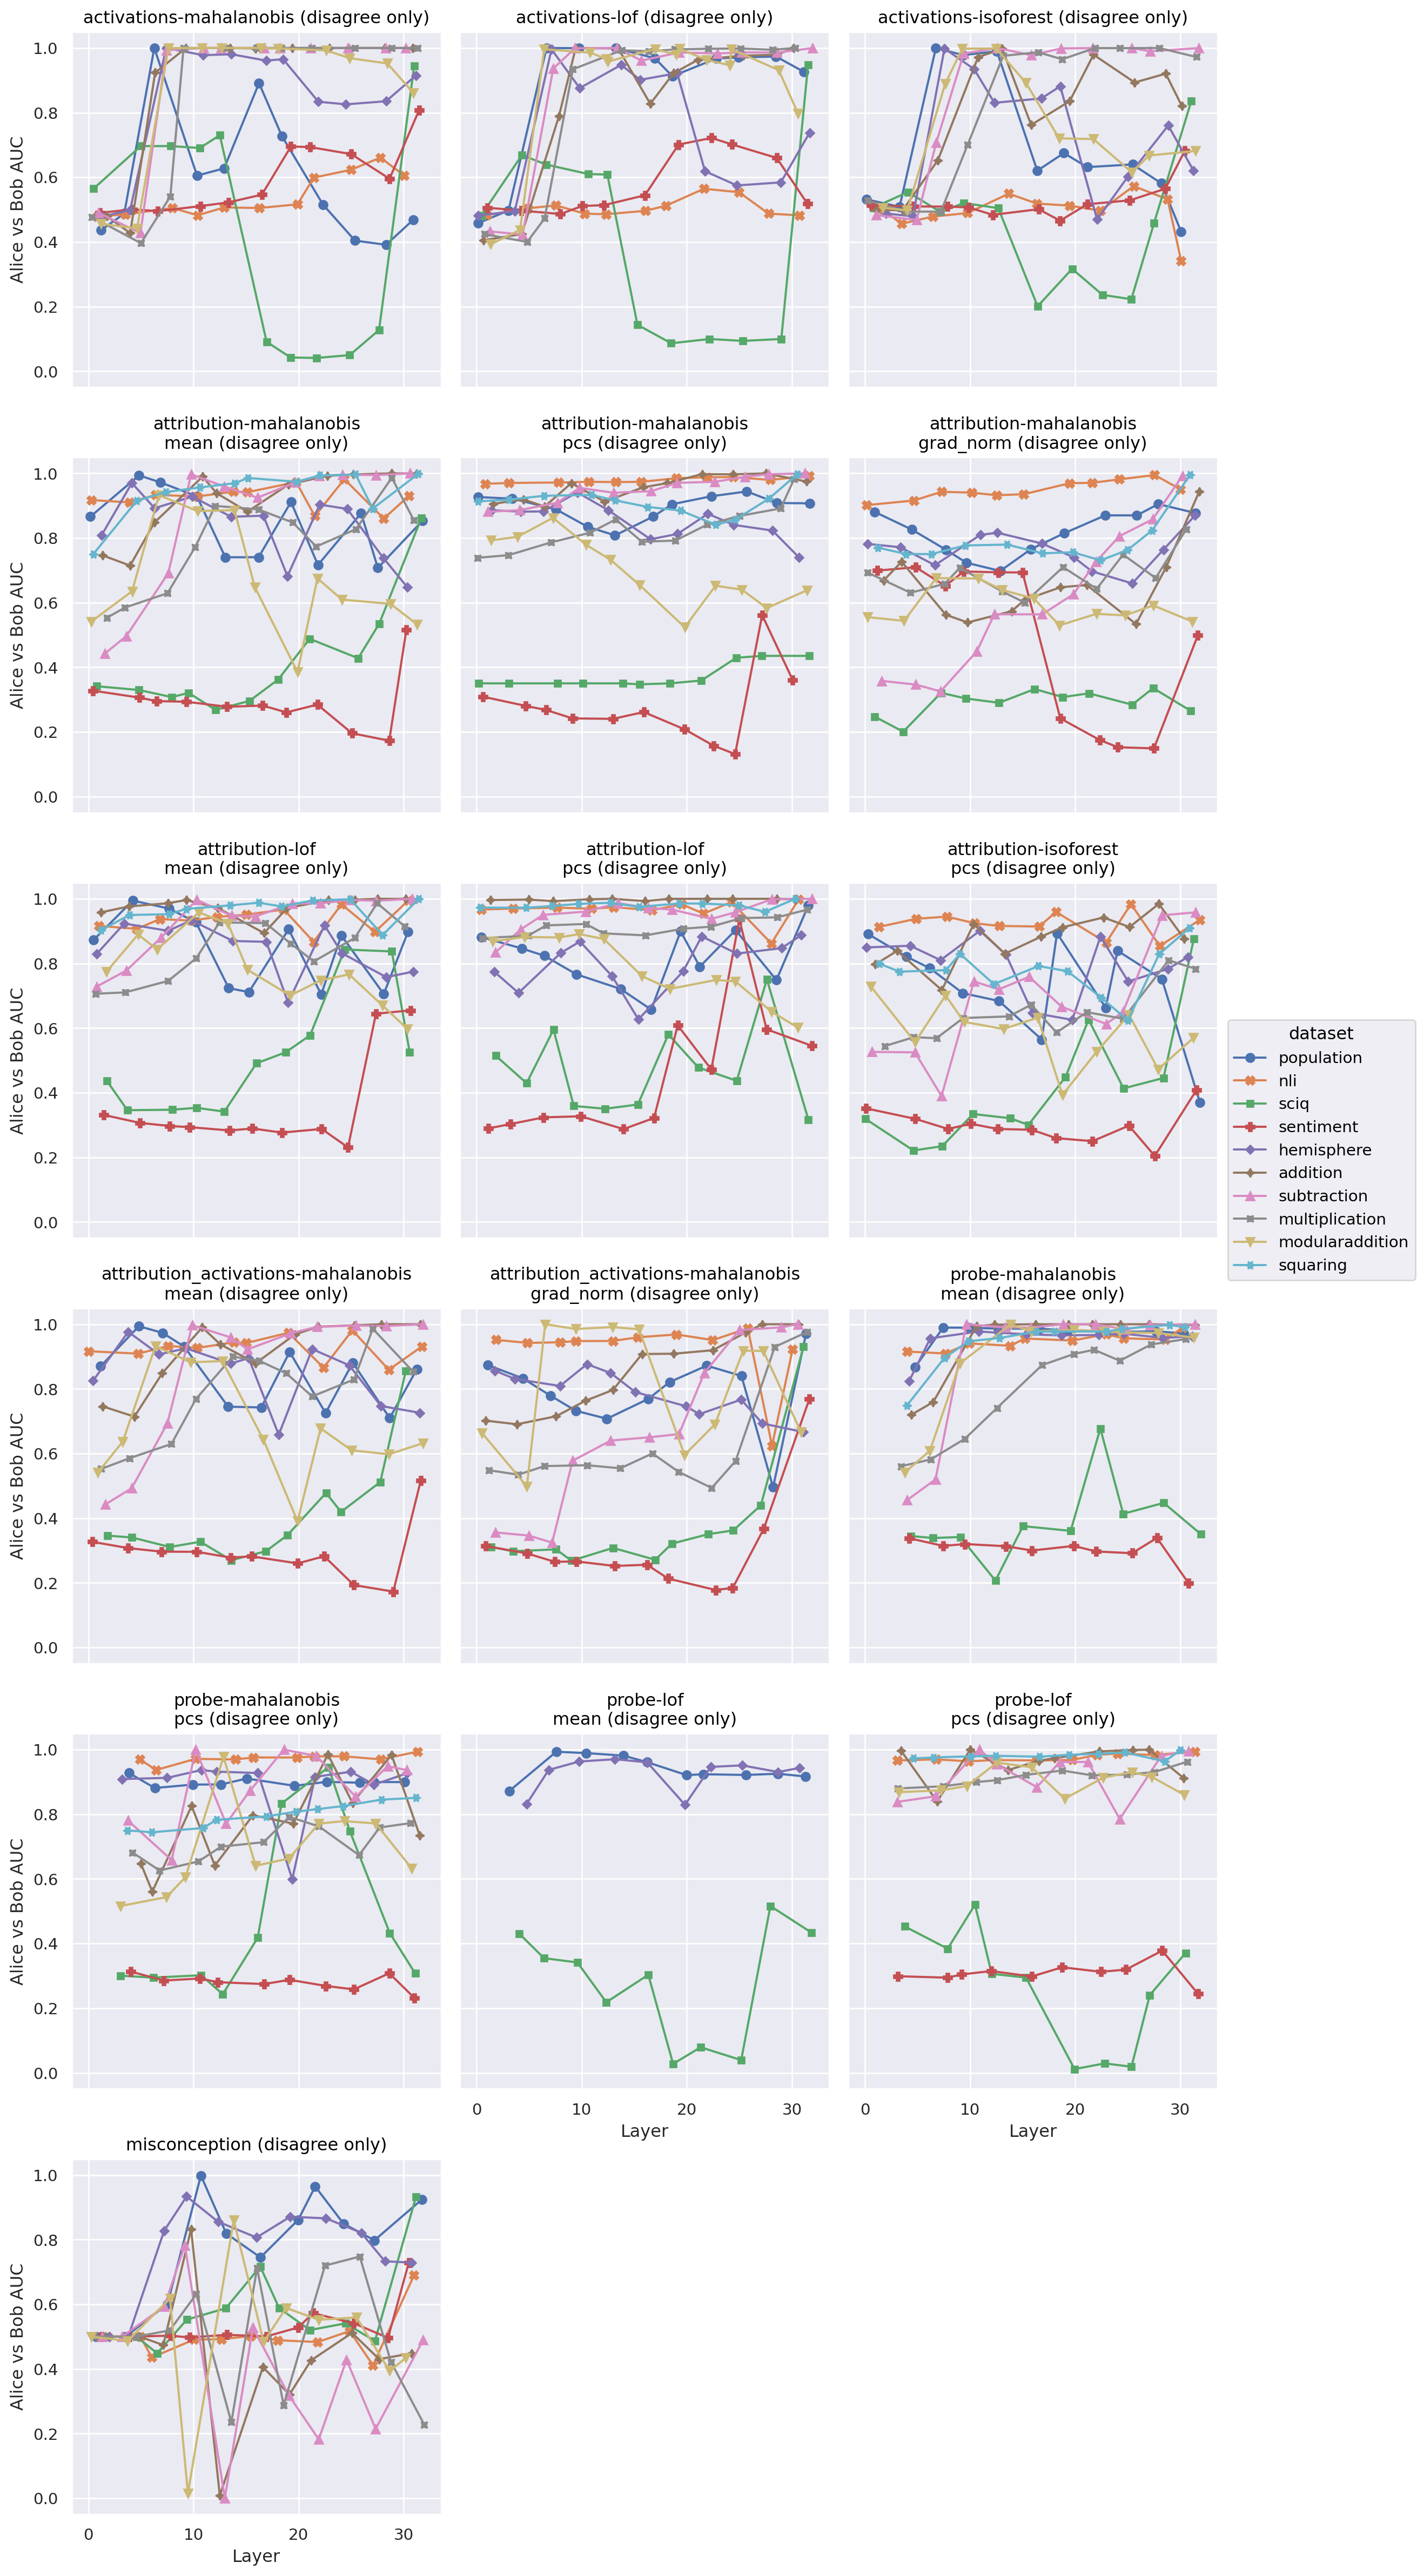

In [91]:
plot_auc_roc_by_layer_by_score(df, disagree=True)

/tmp/ipykernel_3983143/2196524972.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df, mart_df])
/tmp/ipykernel_3983143/584401718.py:244: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


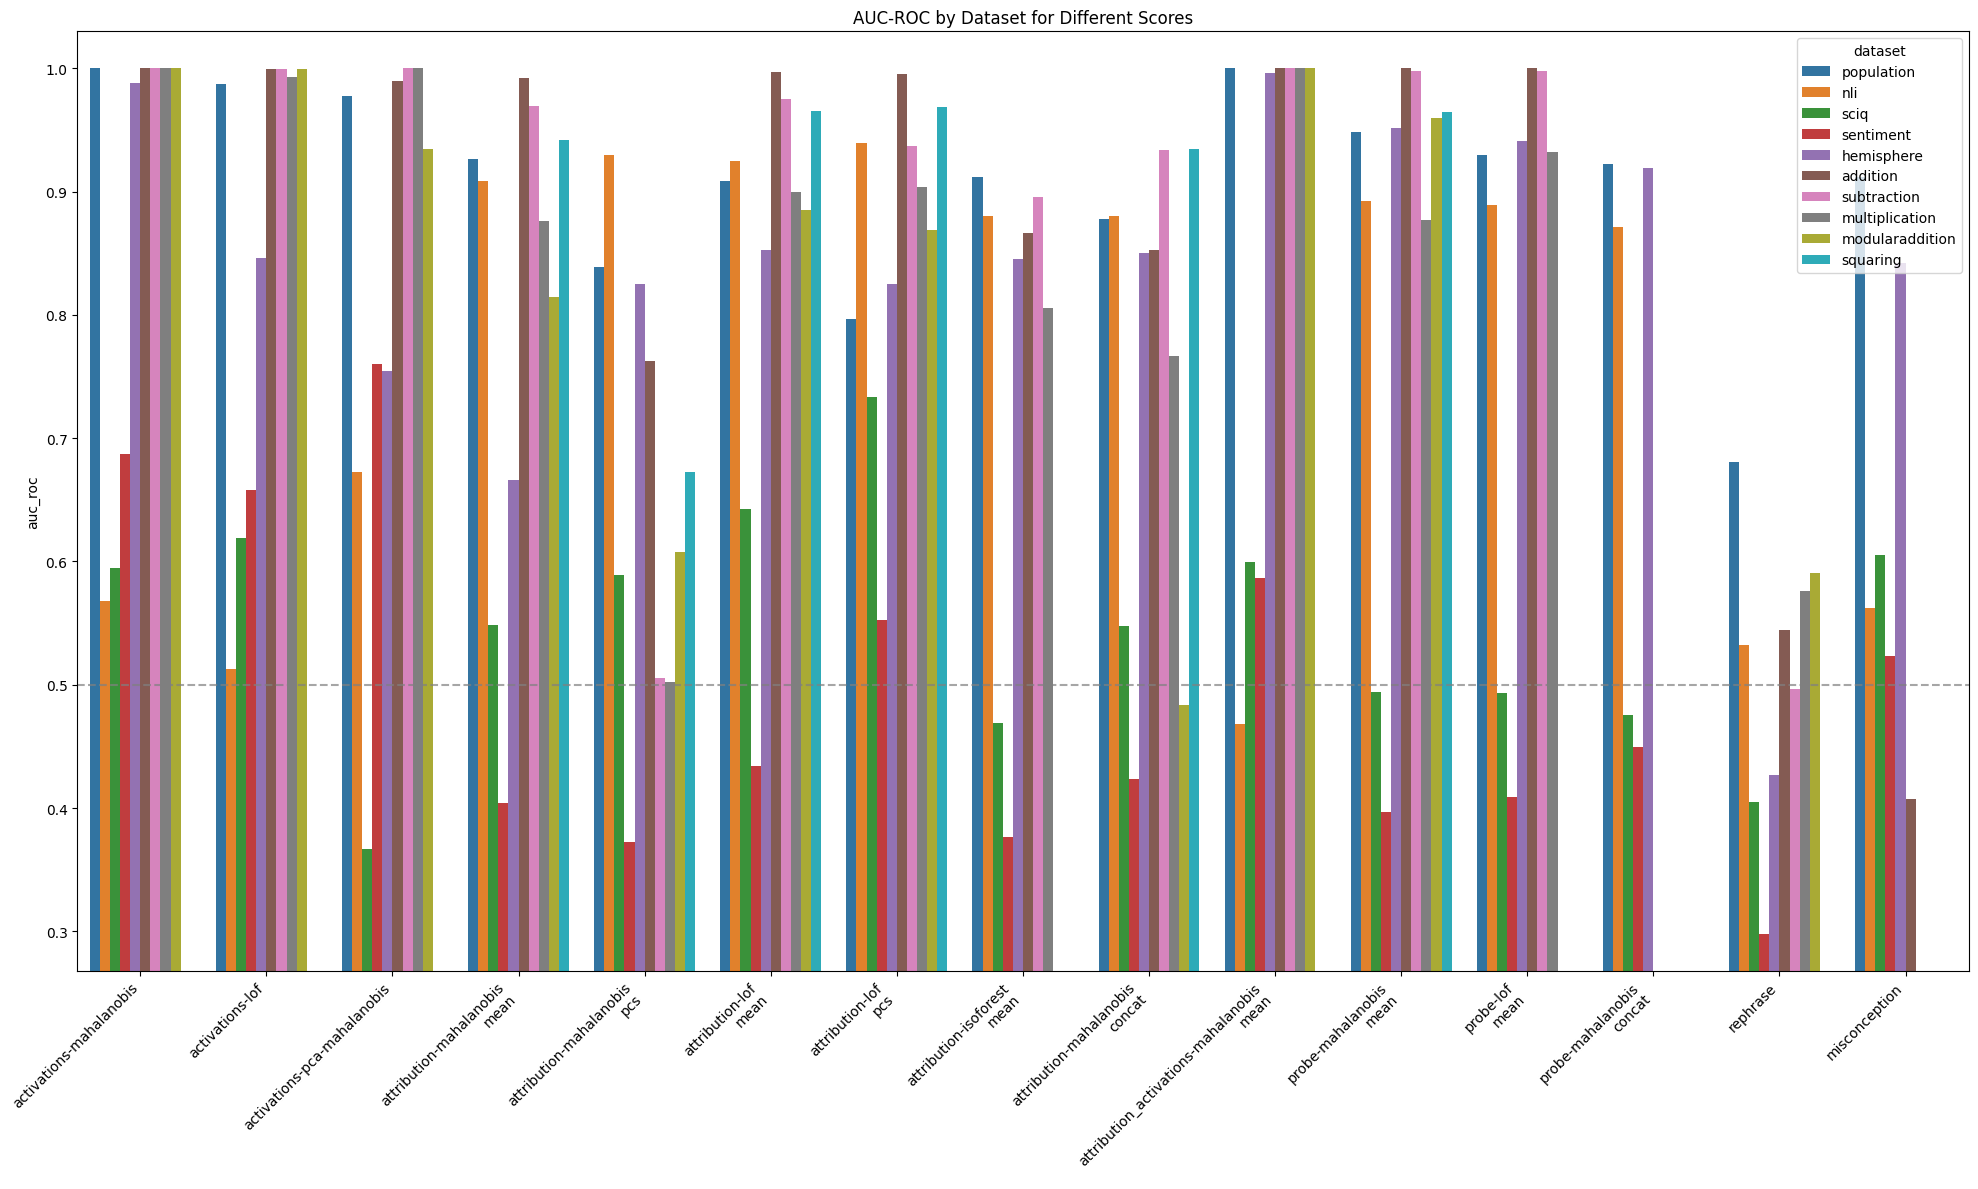

<Axes: title={'center': 'AUC-ROC by Dataset for Different Scores'}, ylabel='auc_roc'>

In [110]:
mart_df = get_data(filters['none'], log_dir=mart_logs_dir)
mart_df['score'] = 'activations-pca-mahalanobis'
df_all = pd.concat([df, mart_df])
df_all['score'] = pd.Categorical(df_all['score'], categories=score_order, ordered=True)

plot_auc_roc_by_layer_by_score(df_all, multilayer=False)


In [216]:
def create_tables(type='online'):
    score_order = offline_score_order if type=='offline' else online_score_order
    df = get_data(filters['layerwise_agnostic'], score_order=score_order)
    df.loc[df['score'].isin(['rephrase']), 'layer'] = -1
    if type == 'online':
        mart_df = get_data(filters['none'], log_dir=mart_logs_dir)
        mart_df['score'] = 'activations-pca-mahalanobis'
        df_all = pd.concat([df, mart_df])
    else:
        df_all = df
    
    df_all = df_all.dropna(subset=['score'])
    df_all['score'] = df_all['score'].astype(str).str.split('-').str[1:].str.join(' ').str.replace('\n', ' ').str.replace('_', ' ')
    
    df_all['features'] = df_all['features'].astype(str).str.replace('_', ' ')
    # First, calculate the best layer for each score and feature selection method
    best_layers = df_all.groupby(['score', 'features', 'layer'])['auc_roc'].mean().groupby(level=[0,1]).idxmax().dropna().apply(lambda x: x[2])

    # Function to get scores for the best layer
    def get_best_layer_scores(group):
        try:
            best_layer = best_layers.loc[group.name[1], group.name[2]]
            best_scores = group[group['layer'] == best_layer]
            if best_scores.empty:
                return pd.Series([np.nan, np.nan, np.nan], index=['auc_roc', 'auc_roc_agree', 'auc_roc_disagree'])
            return best_scores.iloc[0][['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']]
        except KeyError:
            return pd.Series([np.nan, np.nan, np.nan], index=['auc_roc', 'auc_roc_agree', 'auc_roc_disagree'])

    # Calculate scores for the best layers
    best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
    best_layer_scores.columns = ['dataset', 'best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']


    for dataset in df['dataset'].unique():
        dataset_df = df_all[df_all['dataset'] == dataset].drop(columns='dataset')
        
        # Calculate mean scores for this dataset
        mean_scores = dataset_df.groupby(['score', 'features']).agg(np.nanmean)[['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna()
        aggregated_scores = dataset_df.loc[dataset_df['layer']==-1, ['score', 'features', 'auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna()
        aggregated_scores.columns = ['score', 'features', 'aggregated_auc_roc', 'aggregated_auc_roc_agree', 'aggregated_auc_roc_disagree']
        mean_scores.columns = ['mean_auc_roc', 'mean_auc_roc_agree', 'mean_auc_roc_disagree']
        
        # Combine with best layer scores
        combined_scores = mean_scores.join(best_layer_scores.loc[best_layer_scores['dataset'] == dataset, ['best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']])
        combined_scores = combined_scores.join(aggregated_scores.groupby(['score', 'features']).agg(np.nanmean)[['aggregated_auc_roc', 'aggregated_auc_roc_agree', 'aggregated_auc_roc_disagree']])
        
        # Prepare the table
        table = combined_scores.reset_index()
        table['best_layer'] = table.apply(lambda row: best_layers.loc[row['score'], row['features']], axis=1)
        
        table['best_layer'] = table['best_layer'].astype(str).replace('-1', 'aggregate')

        # Reorder columns
        columns = ['score', 'features', 'mean_auc_roc', 'aggregated_auc_roc', 'best_auc_roc', 'mean_auc_roc_agree', 'aggregated_auc_roc_agree', 'best_auc_roc_agree', 
                'mean_auc_roc_disagree', 'aggregated_auc_roc_disagree', 'best_auc_roc_disagree', 'best_layer']
        


        # Function to bold the maximum value in a column
        def bold_max(s):
            is_max = s == s.max()
            return ['**' + f'{v:.3f}' + '**' if is_max.iloc[i] else f'{v:.3f}' for i, v in enumerate(s)]
        
        # Apply bold formatting to numeric columns
        for col in columns[2:-1]:  # Exclude 'score', 'features', and 'best_layer'
            table[col] = bold_max(table[col])
        
        # Convert to markdown
        markdown_table = table[columns].to_markdown(tablefmt="github", index=False)
        
        with open(f"results/{dataset}_{type}_results.md", "w") as f:
            f.write(markdown_table)

    # Calculate overall mean scores across all methods
    overall_mean = df_all.groupby(['features', 'score']).agg({
        'auc_roc': 'mean',
        'auc_roc_agree': 'mean',
        'auc_roc_disagree': 'mean'
    }).reset_index()

    # Rename columns
    overall_mean.columns = ['features', 'score', 'mean_auc_roc', 'mean_auc_roc_agree', 'mean_auc_roc_disagree']

    # Apply bold formatting to numeric columns
    for col in ['mean_auc_roc', 'mean_auc_roc_agree', 'mean_auc_roc_disagree']:
        overall_mean[col] = bold_max(overall_mean[col])

    # Convert to markdown
    overall_mean_table = overall_mean.to_markdown(tablefmt="github", index=False)

        # Write both tables to the file
    with open(f"results/overall_{type}_results.md", "w") as f:
        f.write("\n\n## Overall Aggregated AUROC by Score and Feature: {type}\n\n")
        f.write(overall_mean_table)

    return df_all


In [217]:
df_all = create_tables('online')
create_tables('offline')

probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobi

/tmp/ipykernel_3983143/3257096009.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df, mart_df])
/tmp/ipykernel_3983143/3257096009.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
/tmp/ipykernel_3983143/3257096009.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded 

probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobi

/tmp/ipykernel_3983143/3257096009.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['score'] = df_all['score'].astype(str).str.split('-').str[1:].str.join(' ').str.replace('\n', ' ').str.replace('_', ' ')
/tmp/ipykernel_3983143/3257096009.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['features'] = df_all['features'].astype(str).str.replace('_', ' ')
/tmp/ipykernel_3983143/3257096009.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

alpha          dataset          score     features  layer  random_names  \
69      NaN      subtraction  que grad norm  attribution     -1             1   
92      NaN              nli  que grad norm  attribution     -1             1   
93      NaN  modularaddition     likelihood  activations     16             1   
94      NaN  modularaddition     likelihood  activations     19             1   
95      NaN  modularaddition     likelihood  activations     22             1   
...     ...              ...            ...          ...    ...           ...   
3668    NaN         addition       que mean        probe     22             1   
3669    NaN         addition       que mean        probe     25             1   
3670    NaN         addition       que mean        probe     28             1   
3671    NaN         addition       que mean        probe     31             1   
3672    NaN         addition       que mean        probe     -1             1   

       auc_roc  auc_roc_agree  auc_roc_disagree  
69    0.592169       0.695101          0.646263  
92    0.888871       0.867337          0.984694  
93    1.000000       1.000000          1.000000  
94    0.999930       0.999916          0.999947  
95    0.992252       0.986771          0.998091  
...        ...            ...               ...  
3668  1.000000       1.000000          1.000000  
3669  0.998504       0.997909          1.000000  
3670  1.000000       1.000000          1.000000  
3671  0.995434       0.997064          0.996628  
3672  1.000000       1.000000          1.000000  

[874 rows x 9 columns]

In [188]:
df_all.drop(columns=['dataset', 'alpha', 'layer', 'random_names']).dropna(subset='score').groupby(['features','score']).apply(np.nanmean)
    # First, calculate the best layer for each score and feature selection method

features                 score                  
activations              isoforest                  0.675248
                         lof                        0.742471
                         mahalanobis                0.739408
                         pca mahalanobis            0.798342
attribution              isoforest mean             0.772794
                         isoforest pcs              0.650937
                         lof mean                   0.786336
                         lof pcs                    0.807742
                         mahalanobis concat mean    0.764831
                         mahalanobis grad norm      0.617309
                         mahalanobis mean           0.735398
                         mahalanobis pcs            0.749940
attribution activations  mahalanobis grad norm      0.671015
                         mahalanobis mean           0.726816
iterative rephrase                                  0.488627
misconception contrast              

In [193]:
df_all['score'].unique()

array(['mahalanobis pcs', 'isoforest', 'lof pcs',
       'mahalanobis concat mean', 'isoforest mean', 'mahalanobis mean',
       'lof', 'mahalanobis grad norm', '', 'lof concat mean',
       'mahalanobis', 'isoforest pcs', 'lof concat pcs', 'lof mean',
       'pca mahalanobis'], dtype=object)

In [145]:
df_all[df_all['features']=='iterative_rephrase']

alpha          dataset     score            features  layer  \
166     NaN             sciq  rephrase  iterative_rephrase     -1   
275     NaN  modularaddition  rephrase  iterative_rephrase     -1   
1022    NaN   multiplication  rephrase  iterative_rephrase     -1   
1590    NaN       hemisphere  rephrase  iterative_rephrase     -1   
1767    NaN              nli  rephrase  iterative_rephrase     -1   
1960    NaN        sentiment  rephrase  iterative_rephrase     -1   
2099    NaN      subtraction  rephrase  iterative_rephrase     -1   
2242    NaN         addition  rephrase  iterative_rephrase     -1   
2705    NaN       population  rephrase  iterative_rephrase     -1   

      random_names   auc_roc  auc_roc_agree  auc_roc_disagree  
166              1  0.405154       0.299627          0.199413  
275              1  0.590873       0.594124          0.586586  
1022             1  0.576329       0.630132          0.528508  
1590             1  0.426465       0.518558          0.294000  
1767             1  0.532087       0.382376          0.898589  
1960             1  0.298001       0.299332          0.245995  
2099             1  0.496183       0.476595          0.512407  
2242             1  0.544217       0.356189          0.523831  
2705             1  0.680552       0.783697          0.513108